In [112]:
%matplotlib inline

# Neural ngram language model (naive implementation)
This is an assignment on implementing an ngram neural language model for French from the course Machine Learning for NLP at the University Paris Cite'.

We will implement a language model
- at a given position i
- it takes as input the two preceding words
- and outputs log_probabilities for each word of the vocabulary

The network will use the concatenation of embeddings of the two preceding words, followed by a MLP with a single hidden layer.

In [113]:
# Inspired by
# voir https://pytorch.org/tutorials/beginner/nlp/word_embeddings_tutorial.html
# by Robert Guthrie


import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import time

torch.manual_seed(1)

In [125]:
# Tiny training corpus: we will use a poem by Andrée Chedid. 
# I extended it with other poems to make it longer. 
# (To tokenize it just split on spaces)
train_sent = """
Mon autre , mon semblable ,
en cette chair qui se démène ,
en ce sang qui cavalcade ,
en ce complot du temps ,
en cette mort qui nous guette ,
en cette fraternité de nos fugaces vies ,
mon semblable , mon autre ,
là où tu es je suis .
Le hasard ne cesse de ramener vers nos rivages 
quelques merveilles que nous n' avions pas cueillies ,
quelques malheurs que nous n' avions pas ourdis .
Surgi des ténèbres ou de l ' éclair ,
le hasard pose tantôt son aile sur notre épaule ,
tantôt ses griffes dans la chair de nos vies .
Le présent se fait vide et triste,
Ô mon amie, autour de nous ;
Combien peu de passé subsiste !
Et ceux qui restent changent tous .
Nous ne voyons plus sans envie
Les yeux de vingt ans resplendir ,
Et combien sont déjà sans vie
Des yeux qui nous ont vus grandir !
Que de jeunesse emporte l ' heure ,
Qui n ' en rapporte jamais rien !
Pourtant quelque chose demeure :
Je t ' aime avec mon cœur ancien ,
Mon vrai cœur, celui qui s ' attache
Et souffre depuis qu ' il est né ,
Mon cœur d ' enfant, le cœur sans tache
Que ma mère m ' avait donné ;
Ce cœur où plus rien ne pénètre,
D ' où plus rien désormais ne sort ;
Je t ' aime avec ce que mon être
A de plus fort contre la mort ;
Et, s ' il peut braver la mort même ,
Si le meilleur de l ' homme est tel
Que rien n ' en périsse, je t ' aime
Avec ce que j ' ai d ' immortel .
Dans l ' interminable
Ennui de la plaine ,
La neige incertaine
Luit comme du sable .
Le ciel est de cuivre
Sans lueur aucune ,
On croirait voir vivre
Et mourir la lune .
Comme des nuées
Flottent gris les chênes
Des forêts prochaines
Parmi les buées .
Le ciel est de cuivre
Sans lueur aucune .
On croirait voir vivre
Et mourir la lune .
Corneille poussive
Et vous , les loups maigres ,
Par ces bises aigres
Quoi donc vous arrive ?
Dans l ' interminable
Ennui de la plaine
La neige incertaine
Luit comme du sable .
Un taxi noir ,
Celui d ' après minuit ,
Mon chauffeur slame ,
Mixe de plusieurs langues ,
Et ses sourcils de loup-garou ,
Dans les nuits fauves de Beyrouth ,
Cette montagne dressée au loin ,
Constellation d ' un Pollock en transe ,
Je décroche
À côté de mes pompes ,
Tel un somnambule ,
La ville jappe ,
Puis bat la mesure en rythme ,
Par la fenêtre
Des fils électriques tressés à l ' infini ,
Tout va trop vite ,
Ça défile ,
Appartements percés de part en part ,
Éclats de balle ,
Des trous de la taille d ' un obus ,
Un goût de poussière ,
Odeur de pneus brûlés ,
Ma tête prête à exploser ,
Comme si des doigts essayaient de me faire avouer
Mais quoi ?
Je délire ,
Un gamin court après la voiture ,
Le feu passe au rouge ,
Des scooters nous tournent autour ,
Haine de l ' étranger ,
Je fonce
Sur les bords de mer ,
La lune fait du sur-place ,
Le ciel pris de folie ,
Des lucioles rebondissent sur le sable ,
Des chars défilent ,
Tremblement ,
La terre entame son solo de jazz ,
Je rêve d' une femme ,
La peau claire ,
Aux cheveux noirs ,
Mais j ' ai droit à la lampe
d ' un militaire ,
Braquée sur mon désir ,
Il nous fait ranger sur le bas-côté ,
Fouille au corps ,
Vérification des papiers ,
Le loup-garou ne veut pas aller plus loin ,
Je longe la plage ,
Des couples se cachent dans des voitures
Tous phares éteints ,
Dans l ' eau, elle est là ,
La femme à la peau claire ,
Aux cheveux noirs ,
Elle n ' a pas peur des flammes ,
Des reflets brûlants sur les vagues ,
Nous plongeons
Sous l ' eau, une autre nuit ,
Une longue phrase ,
Sans un mot ,
« A love » suprême .
Dans l ' interminable
Ennui de la plaine ,
La neige incertaine
Luit comme du sable .
Le ciel est de cuivre
Sans lueur aucune ,
On croirait voir vivre
Et mourir la lune .
Comme des nuées
Flottent gris les chênes
Des forêts prochaines
Parmi les buées .
Le ciel est de cuivre
Sans lueur aucune .
On croirait voir vivre
Et mourir la lune .
Corneille poussive
Et vous , les loups maigres ,
Par ces bises aigres
Quoi donc vous arrive ?
Dans l ' interminable
Ennui de la plaine
La neige incertaine
Luit comme du sable .
J ' ai regardé devant moi
Dans la foule je t ' ai vue
Parmi les blés je t ' ai vue
Sous un arbre je t ' ai vue
Au bout de tous mes voyages
Au fond de tous mes tourments
Au tournant de tous les rires
Sortant de l ' eau et du feu
L ' été l ' hiver je t ' ai vue
Dans ma maison je t ' ai vue
Entre mes bras je t ' ai vue
Dans mes rêves je t ' ai vue
Je ne te quitterai plus .
La neige au loin couvre la terre nue ;
Les bois déserts étendent vers la nue
Leurs grands rameaux qui, noirs et séparés ,
D ' aucune feuille encor ne sont parés ;
La sève dort et le bourgeon sans force
Est pour longtemps engourdi sous l ' écorce ;
L ' ouragan souffle en proclamant l ' hiver
Qui vient glacer l ' horizon découvert .
Mais j ' ai frémi sous d ' invisibles flammes
Voix du printemps qui remuez les âmes ,
Quand tout est froid et mort autour de nous ,
Voix du printemps , ô voix , d ' où venez-vous ? …
A chaque fois que la neige tombe ,
Je crois voir un ange
sur un fil transparent .
La danse de cette délicate créature
est différente chaque fois .
Toute sa blancheur ,
pure et brillante ,
nous entoure , il semble , pour toujours .
La pure et fine Blanche Neige ,
empreintée de soleils et de lunes ,
n ' a pas pu voir les hommes
emportés par le vent .
Cette fée de l ' hiver
n ' a pas senti l ' odeur de la guerre .
Elle n ' a pas eu le moment de réfléchir .
Mais elle sait que son cœur , pur et jeune ,
est rempli de rêves et de rimes
qu ' elle n ' a pas encore exprimés .
Elle commence une nouvelle année
avec un frisson du Nord dans le corps .
Les anges les anges dans le ciel
L ' un est vêtu en officier
L ' un est vêtu en cuisinier
Et les autres chantent
Bel officier couleur du ciel
Le doux printemps longtemps après Noël
Te médaillera d ' un beau soleil
D ' un beau soleil
Le cuisinier plume les oies
Ah ! tombe neige
Tombe et que n ' ai-je
Ma bien-aimée entre mes bras
La neige est si belle sur les arbres
lorsque s ' empilent petit à petit
tous les flocons qui tombent du ciel
Tout est blanc et couleur d ' écorce
et quelques oiseaux qui brillent comme des étoiles
au milieu de ce ciel de jour où le bleu est parti
Un rouge-gorge
Une mésange
Orange
virevoltent autour de la mangeoire
Et le grand pré est si blanc
Blanc
Comme une toile moelleuse
Comme une toile d ' Hiver
Où les couleurs de vie
ne partiront jamais
Je ne peux rien retenir ,
Ni la lune ni la brise ,
Ni la couleur rose et grise
D ' un étang plein de dormir ;
Ni l ' amitié ni ma vie ,
Ombre fuyante et pâlie
Dont je perds le souvenir .
Main dans la main marchent
la neige et le silence
Du monde lavé
de ses souillures
s ' élève le chant
le plus pur
Les hommes prennent
un étrange bain
d ' innocence
Ils échangent leurs cœurs
boules de candeur
que leurs rires illuminent
Voyez comme ici-bas
la fraternité a bonne mine
Il suffit de peu
que deux amoureux
main dans la main
regardent en silence
tomber la neige
de leur enfance
""".split()

# Build list of examples:  each example is ([ word_i-2, word_i-1 ], target word)
train_examples = [( [ train_sent[i], train_sent[i+1] ], train_sent[i+2] ) 
                  for i in range(len(train_sent) - 2)]

# print the first 3, just so you can see what they look like
print(train_sent[:9])
print(train_examples[:3])

vocab = set(train_sent)
# I updated the vocab to include an UNK token, for the dev set.
vocab.update(['UNK'])

w2i = {word: i for i, word in enumerate(vocab)}
i2w = {i: word for i, word in enumerate(vocab)}

# encode the training examples into word ids
train_examples =  [ ( [ w2i[ex[0][0]], w2i[ex[0][1]] ], w2i[ex[1]] ) for ex in train_examples ]
print(train_examples[:3])
print(len(w2i))
print(w2i['UNK'])
print(w2i['la'])


['Mon', 'autre', ',', 'mon', 'semblable', ',', 'en', 'cette', 'chair']
[(['Mon', 'autre'], ','), (['autre', ','], 'mon'), ([',', 'mon'], 'semblable')]
[([141, 283], 65), ([283, 65], 401), ([65, 401], 534)]
580
413
529


In [115]:
class NGramLanguageModel(nn.Module):

    def __init__(self, vocab_size, embedding_size, context_size, hidden_layer_size, early_stop = False):
        super(NGramLanguageModel, self).__init__()
        # the target network should work as follows:
        #  for a single input
        # - input =  context_size word ids (context words)
        #    => retrieval of their embeddings
        #    => concatenation (see the forward method below)
        # - which provides the "embedding layer"
        #    => linear combination
        #    => reLU
        # - which provides the "hidden layer"
        #    => linear combination
        #    => log_softmax
        # - which provides log probabilities over the full vocabulary
        
        # but remember nn.Module works with a batch of inputs, not a single input
        
        self.embeddings = nn.Embedding(vocab_size, embedding_size) # embedding layer [VOCAB_SIZE, EMB_SIZE]
        self.linear1 = nn.Linear(context_size * embedding_size, hidden_layer_size) # hidden layer [CONTEXT_SIZE * EMB_SIZE, HIDDEN_LAYER_SIZE]
        self.linear2 = nn.Linear(hidden_layer_size, vocab_size) # output layer [HIDDEN_LAYER_SIZE, VOCAB_SIZE]
        self.early_stop = early_stop
        
        # TODO: define the size of the embedding layer, the hidden layer, the output
        #       as a function of the batch size and the arguments :
        #       vocab_size, embedding_size, context_size, hidden_layer_size
        

        # TODO: and then : define the needed nn.Linear members, for the linear combinations cited above
        
        

    def forward(self, inputs):
        # Look up embeddings:
        size = inputs.size()              # [BATCH_SIZE, CONTEXT_SIZE]
        embeds = self.embeddings(inputs)  # [BATCH_SIZE, CONTEXT_SIZE, EMB_SIZE]
        embeds = embeds.view(size[0], -1) # [BATCH_SIZE, CONTEXT_SIZE * EMB_SIZE] : concatenation of the 2 embeddings

        # TODO: continue the forward propagation
        #  (cf. description above of what the network should do)
        #  to output log probabilities, F.log_softmax
        #  writing the shape of each additional tensor (as done above)
        
        # W(1) = [CONTEXT_SIZE * EMB_SIZE, HIDDEN_LAYER_SIZE]:
        out = self.linear1(embeds) # [BATCH_SIZE, HIDDEN_LAYER_SIZE]
        
        # Activation function (ReLU) at the hidden layer:
        out = torch.relu(out) # [BATCH_SIZE, HIDDEN_LAYER_SIZE]
        
        # W(2) = [HIDDEN_LAYER_SIZE, VOCAB_SIZE]:
        out = self.linear2(out) # [BATCH_SIZE, VOCAB_SIZE]
        
        # Log softmax at the output layer:
        log_probs = F.log_softmax(out, dim=1) # [BATCH_SIZE, VOCAB_SIZE] 
            
        return log_probs



In [116]:
CONTEXT_SIZE = 2
EMB_SIZE = 10
HIDDEN_LAYER_SIZE = 128
EARLY_STOP = False # set to True to setup the model for early stopping


# instance of NGramLanguageModel
my_language_model = NGramLanguageModel(len(vocab), EMB_SIZE, CONTEXT_SIZE, HIDDEN_LAYER_SIZE, EARLY_STOP)


In [117]:
dev_sent = """Le temps passe
Nos jours se remplissent
De choses légères
Et de tout ce qui est si important
Libre de penser comme on veut
On finit par ne penser que comme on peut
Comme un flocon de neige
Qui tremble dans l ' air
La chute est lente
Le vent déroute
Mais le chemin reste
Inexorable""".split()
# Convert the dev set to word ids using w2i
dev_sent = [w2i[sent] if sent in w2i else w2i['UNK'] for sent in dev_sent]
print(dev_sent)

# Create the dev examples
dev_examples = [( [ dev_sent[i], dev_sent[i+1] ], dev_sent[i+2] ) for i in range(len(dev_sent) - 2)]
print(dev_examples[:3])
print(train_examples[:3])
                

[447, 311, 154, 413, 413, 354, 413, 413, 413, 413, 456, 572, 333, 285, 383, 113, 218, 413, 413, 572, 413, 191, 413, 3, 256, 413, 375, 518, 413, 372, 191, 413, 400, 178, 247, 413, 572, 391, 351, 413, 284, 49, 177, 413, 162, 413, 113, 413, 447, 355, 413, 163, 566, 413, 413, 413]
[([447, 311], 154), ([311, 154], 413), ([154, 413], 413)]
[([141, 283], 65), ([283, 65], 401), ([65, 401], 534)]


Loss on training set at epoch 0 : 1735.507105
Loss on training set at epoch 1 : 1554.402524
Loss on training set at epoch 2 : 1435.705132
Loss on training set at epoch 3 : 1327.400919
Loss on training set at epoch 4 : 1224.880941
Loss on training set at epoch 5 : 1119.452299
Loss on training set at epoch 6 : 1014.844982
Loss on training set at epoch 7 : 907.735990
Loss on training set at epoch 8 : 807.912312
Loss on training set at epoch 9 : 714.934506
Loss on training set at epoch 10 : 629.221910
Loss on training set at epoch 11 : 557.057322
Loss on training set at epoch 12 : 489.071733
Loss on training set at epoch 13 : 439.642015
Loss on training set at epoch 14 : 396.133312
Loss on training set at epoch 15 : 359.101076
Loss on training set at epoch 16 : 326.762573
Loss on training set at epoch 17 : 302.405286
Loss on training set at epoch 18 : 283.942619
Loss on training set at epoch 19 : 258.426174
Loss on training set at epoch 20 : 249.858495
Loss on training set at epoch 21 : 22

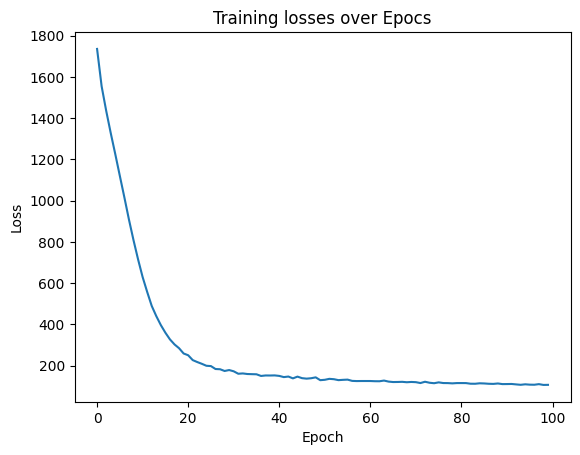

Loss on dev set after training: 15.010509

The predicted text is:  ['la', 'en', "'", "'", 'd', '!', "'", "'", "'", 'les', 'la', ',', 'de', 'm', ',', 'blanc', 'Des', "'", ',', 'ciel', 'qui', 'petit', 'd', 'croirait', 'forêts', ',', 'arbre', 'de', 'la', ',', 'petit', 't', 'tombe', 'les', 'bain', ',', 'Tombe', 'vient', "'", 'd', "'", 'interminable', 'petit', 'de', 'jappe', 'né', 's', 't', 'ne', "'", 'j', "'", '.', "'"]
The original text is:  ['Le', 'temps', 'passe', 'UNK', 'UNK', 'se', 'UNK', 'UNK', 'UNK', 'UNK', 'Et', 'de', 'tout', 'ce', 'qui', 'est', 'si', 'UNK', 'UNK', 'de', 'UNK', 'comme', 'UNK', 'veut', 'On', 'UNK', 'par', 'ne', 'UNK', 'que', 'comme', 'UNK', 'peut', 'Comme', 'un', 'UNK', 'de', 'neige', 'Qui', 'UNK', 'dans', 'l', "'", 'UNK', 'La', 'UNK', 'est', 'UNK', 'Le', 'vent', 'UNK', 'Mais', 'le', 'UNK', 'UNK', 'UNK']
Accuracy on dev after training: 1.85

Training time: 23 seconds


In [118]:

# to store the training losses at each epoch
train_losses = []
loss_function = nn.NLLLoss()
t0 = time.time()
# the optimizer is the instance that will actually update the declared parameters
optimizer = optim.SGD(my_language_model.parameters(), lr=0.05)

from random import shuffle

NB_EPOCHS = 100
BATCH_SIZE = 5

for epoch in range(NB_EPOCHS):
    epoch_loss = 0
    
    # shuffle data
    shuffle(train_examples)
    i = 0
    while i < len(train_examples):
        
        batch = train_examples[i: i+BATCH_SIZE]
        i += BATCH_SIZE
        
        contexts, targets = zip(*batch)

        # Step 1. Prepare the inputs to be passed to the model 
        input_tensor = torch.tensor(contexts, dtype=torch.long) # [BATCH_SIZE, CONTEXT_SIZE]
        gold_labels = torch.tensor(targets, dtype=torch.long)   # [BATCH_SIZE]
        
        # TODO : continue the learning (cf. previous lab session TD7)
        # Step 2. Reset gradients to 0
        my_language_model.zero_grad()
        
        # Step 3. Forward propagation
        my_language_model(input_tensor)
        
        # Step 4. Compute the loss and add training loss to the epoch loss
        loss = loss_function(my_language_model(input_tensor), gold_labels)
        epoch_loss += loss.item()
        
        # Step 5. Backward propagation
        loss.backward()
        
        # Step 6. Update the parameters
        optimizer.step()        
        
    # end of handling of this batch
    print("Loss on training set at epoch %d : %f" %(epoch, epoch_loss))
    train_losses.append(epoch_loss)
    # Step 7. Early stopping
    if my_language_model.early_stop:
        with torch.no_grad():
            # forward propagation
            # We convert the dev examples to tensors and do the forward propagation
            dev_contexts, dev_targets = zip(*dev_examples)
            dev_input_tensor = torch.tensor(dev_contexts, dtype=torch.long) # [DEV_SIZE, CONTEXT_SIZE]
            dev_gold_labels = torch.tensor(dev_targets, dtype=torch.long)   # [DEV_SIZE]        
            log_probs = my_language_model(dev_input_tensor)  
            
            # total loss on the dev set
            dev_loss = loss_function(log_probs, dev_gold_labels)
            print("Loss on dev set at epoch %d: %f\n" %(epoch, dev_loss))
            
            # prediction and accuracy on the dev set
            pred_labels = torch.argmax(log_probs, dim=1)
            accuracy = torch.sum(pred_labels == dev_gold_labels).item() / len(dev_gold_labels)
            print("Accuracy on dev, after epoch %d: %3.2f\n" % (epoch, accuracy * 100))
            
            # early stopping
            # if first epoch: we record the dev loss, to be used for early stopping
            if epoch == 0:
                previous_dev_loss = dev_loss
            elif dev_loss - previous_dev_loss > 0.55:
                print("Loss on dev has increased, we stop training!")
                break
            else:
                previous_dev_loss = dev_loss
# Plot the training losses
plt.plot(train_losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training losses over Epocs")
plt.show()

# Test on dev set after training:
with torch.no_grad():
    # forward propagation on dev set
    dev_contexts, dev_targets = zip(*dev_examples)
    dev_input_tensor = torch.tensor(dev_contexts, dtype=torch.long) # [DEV_SIZE, CONTEXT_SIZE]
    dev_gold_labels = torch.tensor(dev_targets, dtype=torch.long)   # [DEV_SIZE]
    log_probs = my_language_model(dev_input_tensor) 
    
    # total loss on the dev set
    dev_loss = loss_function(log_probs, dev_gold_labels)
    print("Loss on dev set after training: %f\n" %(dev_loss))
            
    # prediction and accuracy on the dev set
    pred_labels = torch.argmax(log_probs, dim=1)
    accuracy = torch.sum(pred_labels == dev_gold_labels).item() / len(dev_gold_labels)
    pred_labels = pred_labels.tolist()
    pred_labels = [i2w[pred] for pred in pred_labels]
    print("The predicted text is: ", pred_labels)
    dev_sent = [i2w[sent] for sent in dev_sent]
    print("The original text is: ", dev_sent)
    print("Accuracy on dev after training: %3.2f\n" % (accuracy * 100))
t_end = time.time() - t0
print("Training time: %d seconds" % t_end)
    


### To go further

- display the learning curve on the train set
- use of a dev set to tune the number of epochs using early stopping 
- handling of unknown words
- ...

I think the accuracy result on the dev set is very interesting and highlights the difficulty of the language models. The accuracy is really low, and the prediction is overly preferring the most frequent symbols, which are the commas and the apostropes. I have seen some LLM models running on a laptop (GPT4All based on GPT-J) that generate a few sentences quite well, but then trail off into just generating commas instead of words. The low accuracy can be explained by the size and the genre of the training corpus.

In [119]:
# From this language model, we can extract the word embeddings of the words in the vocabulary
import numpy as np
vector_space = my_language_model.embeddings.weight.data

print(vector_space.shape) # [VOCAB_SIZE, EMBEDDING_SIZE]

print(f"The vector of the word '{i2w[0]}' is: {vector_space[0]}")

def cosine_similarity(vec1, vec2):
    return np.dot(vec1, vec2) / (np.linalg.norm(vec1) * np.linalg.norm(vec2))

# We can calculate the intrinsic evaluation of the word embeddings by cosine similarity.
# The task has to be compared to the ratings of human annotators, using Pearson/Spearman coefficient.
print(vocab)
print(f"The cosine similarity between the vectors of 'Blanc' and 'Neige' is: {cosine_similarity(vector_space[w2i['Blanc']], vector_space[w2i['Neige']])}")
print(f"The cosine similarity between the vectors of 'brûlés' and 'chauffeur' is: {cosine_similarity(vector_space[w2i['brûlés']], vector_space[w2i['chauffeur']])}")
print(f"The cosine similarity between the vectors of 'ancien' and 'jeune' is: {cosine_similarity(vector_space[w2i['ancien']], vector_space[w2i['jeune']])}")

# Or we can do the analogy task:
print(f"'soleil' - 'soleils' compared to 'ange' - 'anges': {cosine_similarity(vector_space[w2i['soleil']], vector_space[w2i['soleils']])} vs {cosine_similarity(vector_space[w2i['ange']], vector_space[w2i['anges']])}")
print(f"'rêve' - 'rêves' compared to 'soleil' - 'soleils': {cosine_similarity(vector_space[w2i['rêve']], vector_space[w2i['rêves']])} vs {cosine_similarity(vector_space[w2i['soleil']], vector_space[w2i['soleils']])}" )

# We can calculate the extrinsic evaluation of the word embeddings by using them as features for a downstream task.


torch.Size([580, 10])
The vector of the word 'rêves' is: tensor([-1.4680, -0.8062, -0.5976, -1.1657, -0.0902, -0.6684, -1.0079, -1.7155,
        -0.7234,  0.6630])
{'rêves', 'guerre', 'd', 'veut', 'cuivre', 'quitterai', 'fugaces', 'Une', 'maison', 'aime', 'oiseaux', 'Blanc', 'fonce', 'quoi', 'droit', 'Cette', 'enfant,', 'ceux', 'bas-côté', 'Tremblement', 'aigres', 'Sous', 'cœurs', 'engourdi', 'avait', 'lampe', 'là', 'nuits', 'blanc', 'défilent', 'Orange', 'perds', 'donc', 'écorce', 'emportés', 'braver', 'tel', 'merveilles', 'plusieurs', 'avec', 'dressée', 'rivages', 'D', 'Quand', 'transe', 'Constellation', 'grands', 'bain', 'jazz', 'l', 'médaillera', 'prennent', 'À', 'jamais', 'cœur', 'éclair', 'bat', 'folie', 'tous', 'infini', 'sa', 'slame', 'cuisinier', 'es', '«', ',', 'nuées', 'autres', 'Ni', 'hommes', 'qui,', 'grand', 'j', 'fil', 'Ô', 'voix', 't', 'jeune', 'dort', 'année', 'loin', 'trop', 'bleu', 'balle', 'lavé', 'souffle', 'son', 'Neige', 'vide', 'entame', 'Où', 'sort', 'brûlés', 

In [157]:
# We can also try this on a larger training corpus, the EP-FR corpus:
# Read the corpora:
def read_examples(filename):
    examples = []
    with open(filename, "r", encoding="utf-8") as f:
        for line in f:
            examples += line.split()
    return examples

train_sent = read_examples("ep-fr.tok.train")
test_sent = read_examples("ep-fr.tok.test")
dev_sent = read_examples("ep-fr.tok.dev")

# Build the vocabulary and the w2i and i2w dictionaries:
vocab = set(train_sent)
# I updated the vocab to include an UNK token, for the dev set.
vocab.update(['UNK'])

w2i = {word: i for i, word in enumerate(vocab)}
i2w = {i: word for i, word in enumerate(vocab)}

# Convert the train examples to a list of tuples (context, target):
train_examples = [( [ train_sent[i], train_sent[i+1] ], train_sent[i+2] ) 
                  for i in range(len(train_sent) - 2)]

# encode the training examples into word ids
train_examples =  [ ( [ w2i[ex[0][0]], w2i[ex[0][1]] ], w2i[ex[1]] ) for ex in train_examples ]

# Convert the test set to a list of tuples (context, target):
test_examples = [w2i[sent] if sent in w2i else w2i['UNK'] for sent in test_sent]

# Create the test examples
test_examples = [( [ test_examples[i], test_examples[i+1] ], test_examples[i+2] ) for i in range(len(test_examples) - 2)]

# Convert the dev set to a list of tuples (context, target):
dev_examples = [w2i[sent] if sent in w2i else w2i['UNK'] for sent in dev_sent]

# Create the dev examples
dev_examples = [( [ dev_examples[i], dev_examples[i+1] ], dev_examples[i+2] ) for i in range(len(dev_examples) - 2)]

print(w2i['UNK'])
print(train_sent[:10])
print(dev_sent[:10])
print(train_examples[:10])
print(dev_examples[:10])

1711
['Reprise', 'de', 'la', 'session', '(', 'DE', ')', 'Je', 'déclare', 'reprise']
['Cette', 'nouvelle', 'république', "n'", 'a', 'pas', 'encore', 'appris', 'les', 'pratiques']
[([297, 1888], 545), ([1888, 545], 505), ([545, 505], 1613), ([505, 1613], 2372), ([1613, 2372], 187), ([2372, 187], 2059), ([187, 2059], 313), ([2059, 313], 1300), ([313, 1300], 545), ([1300, 545], 505)]
[([1283, 718], 2560), ([718, 2560], 1164), ([2560, 1164], 2500), ([1164, 2500], 538), ([2500, 538], 1881), ([538, 1881], 1711), ([1881, 1711], 2302), ([1711, 2302], 1711), ([2302, 1711], 1711), ([1711, 1711], 611)]


In [158]:
# Define the language model:
CONTEXT_SIZE = 2
EMB_SIZE = 300
HIDDEN_LAYER_SIZE = 128
EARLY_STOP = False # set to True to setup the model for early stopping
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

# instance of NGramLanguageModel
my_language_model = NGramLanguageModel(len(vocab), EMB_SIZE, CONTEXT_SIZE, HIDDEN_LAYER_SIZE, EARLY_STOP)
my_language_model.to(device)



NGramLanguageModel(
  (embeddings): Embedding(2577, 300)
  (linear1): Linear(in_features=600, out_features=128, bias=True)
  (linear2): Linear(in_features=128, out_features=2577, bias=True)
)

Loss on training set at epoch 0 : 16545.970900
Loss on training set at epoch 1 : 13425.525470
Loss on training set at epoch 2 : 11604.366250
Loss on training set at epoch 3 : 10044.943862
Loss on training set at epoch 4 : 8707.498098
Loss on training set at epoch 5 : 7623.804967
Loss on training set at epoch 6 : 6828.776428
Loss on training set at epoch 7 : 6292.513639
Loss on training set at epoch 8 : 5860.747207
Loss on training set at epoch 9 : 5474.409810
Loss on training set at epoch 10 : 5125.707604
Loss on training set at epoch 11 : 4861.496178
Loss on training set at epoch 12 : 4718.730771
Loss on training set at epoch 13 : 4511.669311
Loss on training set at epoch 14 : 4343.286009
Loss on training set at epoch 15 : 4216.105325
Loss on training set at epoch 16 : 4114.833491
Loss on training set at epoch 17 : 4007.618438
Loss on training set at epoch 18 : 3908.790429
Loss on training set at epoch 19 : 3815.694058
Loss on training set at epoch 20 : 3773.496605
Loss on training se

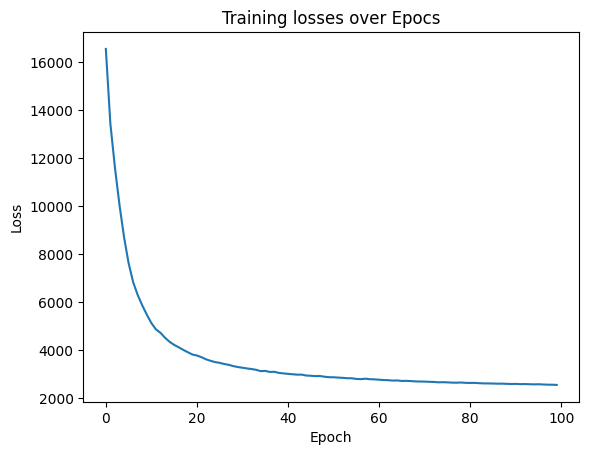

Loss on dev set after training: 11.360039

The predicted text is:  ['se', 'leur', 'a', 'pas', 'à', 'avoir', 'du', 'de', 'de', 'bien', 'de', 'autant', 'en', 'et', 'fait', 'la', 'la', 'un', 'de', "l'", 'UE', 'et', 'la', ',', 'informer', "d'", 'la', 'un', 'autre', 'et', 'de', 'association', 'un', 'bien', 'pour', 'une', 'rigueur', 'un', 'rigueur', 'UE', 'du', "L'", 'le', 'deux', '.', 'Israël', ',', '.', 'le', 'Croatie', 'politique', 'pour', 'Liban', 'la', 'autre', 'pas', 'également', 'à', 'le', 'Balkans', 'qui', "L'", 'États', 'régionales', '(', 'pas', "qu'", 'insolubles', 'dans', 'la', 'situation', 'de', 'qui', 'rigueur', 'UE', 'du', 'une', 'sorte', 'un', 'pour', 'association', 'sur', 'sommet', 'accord', 'est', 'absolument', 'au', 'nom', 'une', 'M.', 'pour', "l'", 'proche', 'que', "l'", 'sur', 'à', 'sorte', 'et', 'le', 'bien', 'la', 'son', 'le', 'sorte', 'un', 'de', 'tirer', 'une', 'solution', 'commune', 'de', 'seulement', 'option', 'un', 'de', 'sous-jacents', "C'", 'feuille', 'le', 'du',

In [159]:

# to store the training losses at each epoch
train_losses = []
loss_function = nn.NLLLoss()
t0 = time.time()
# the optimizer is the instance that will actually update the declared parameters
optimizer = optim.SGD(my_language_model.parameters(), lr=0.05)
from random import shuffle

NB_EPOCHS = 100
BATCH_SIZE = 5

for epoch in range(NB_EPOCHS):
    epoch_loss = 0
    
    # shuffle data
    shuffle(train_examples)
    i = 0
    while i < len(train_examples):
        
        batch = train_examples[i: i+BATCH_SIZE]
        i += BATCH_SIZE
        
        contexts, targets = zip(*batch)

        # Step 1. Prepare the inputs to be passed to the model 
        input_tensor = torch.tensor(contexts, dtype=torch.long).to(device) # [BATCH_SIZE, CONTEXT_SIZE]
        gold_labels = torch.tensor(targets, dtype=torch.long).to(device)   # [BATCH_SIZE]
        
        # TODO : continue the learning (cf. previous lab session TD7)
        # Step 2. Reset gradients to 0
        my_language_model.zero_grad()
        
        # Step 3. Forward propagation
        my_language_model(input_tensor)
        
        # Step 4. Compute the loss and add training loss to the epoch loss
        loss = loss_function(my_language_model(input_tensor), gold_labels)
        epoch_loss += loss.item()
        
        # Step 5. Backward propagation
        loss.backward()
        
        # Step 6. Update the parameters
        optimizer.step()        
        
    # end of handling of this batch
    print("Loss on training set at epoch %d : %f" %(epoch, epoch_loss))
    train_losses.append(epoch_loss)
    # Step 7. Early stopping
    if my_language_model.early_stop:
        with torch.no_grad():
            # forward propagation
            # We convert the dev examples to tensors and do the forward propagation
            dev_contexts, dev_targets = zip(*dev_examples)
            dev_input_tensor = torch.tensor(dev_contexts, dtype=torch.long).to(device) # [DEV_SIZE, CONTEXT_SIZE]
            dev_gold_labels = torch.tensor(dev_targets, dtype=torch.long).to(device)   # [DEV_SIZE]        
            log_probs = my_language_model(dev_input_tensor)  
            
            # total loss on the dev set
            dev_loss = loss_function(log_probs, dev_gold_labels)
            print("Loss on dev set at epoch %d: %f\n" %(epoch, dev_loss))
            
            # prediction and accuracy on the dev set
            pred_labels = torch.argmax(log_probs, dim=1)
            accuracy = torch.sum(pred_labels == dev_gold_labels).item() / len(dev_gold_labels)
            print("Accuracy on dev, after epoch %d: %3.2f\n" % (epoch, accuracy * 100))
            
            # early stopping
            # if first epoch: we record the dev loss, to be used for early stopping
            if epoch == 0:
                previous_dev_loss = dev_loss
            elif dev_loss - previous_dev_loss > 0.45:
                print("Loss on dev has increased, we stop training!")
                break
            else:
                previous_dev_loss = dev_loss
# Plot the training losses
plt.plot(train_losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training losses over Epocs")
plt.show()

# Test on dev set after training:
with torch.no_grad():
    # forward propagation on dev set
    dev_contexts, dev_targets = zip(*dev_examples)
    dev_input_tensor = torch.tensor(dev_contexts, dtype=torch.long).to(device) # [DEV_SIZE, CONTEXT_SIZE]
    dev_gold_labels = torch.tensor(dev_targets, dtype=torch.long).to(device)   # [DEV_SIZE]
    log_probs = my_language_model(dev_input_tensor) 
    
    # total loss on the dev set
    dev_loss = loss_function(log_probs, dev_gold_labels)
    print("Loss on dev set after training: %f\n" %(dev_loss))
            
    # prediction and accuracy on the dev set
    pred_labels = torch.argmax(log_probs, dim=1)
    accuracy = torch.sum(pred_labels == dev_gold_labels).item() / len(dev_gold_labels)
    pred_labels = pred_labels.tolist()
    pred_labels = [i2w[pred] for pred in pred_labels]
    print("The predicted text is: ", pred_labels)
    print("The original text is: ", dev_sent)
    print("Accuracy on dev after training: %3.2f\n" % (accuracy * 100))
t_end = time.time() - t0
print("Training time: %d seconds" % t_end)
    


In [169]:
# From this language model, we can extract the word embeddings of the words in the vocabulary
import numpy as np
vector_space = my_language_model.embeddings.weight.data.cpu()

print(vector_space.shape) # [VOCAB_SIZE, EMBEDDING_SIZE]

#print(f"The vector of the word '{i2w[0]}' is: {vector_space[0]}")

def cosine_similarity(vec1, vec2):
    return np.dot(vec1, vec2) / (np.linalg.norm(vec1) * np.linalg.norm(vec2))

# We can calculate the intrinsic evaluation of the word embeddings by cosine similarity.
# The task has to be compared to the ratings of human annotators, using Pearson/Spearman coefficient.
print(vocab)
print(f"The cosine similarity between the vectors of 'Suisse' and 'Iran' is: {cosine_similarity(vector_space[w2i['Suisse']], vector_space[w2i['Iran']])}")
print(f"The cosine similarity between the vectors of 'Belgique' and 'Suisse' is: {cosine_similarity(vector_space[w2i['Belgique']], vector_space[w2i['Suisse']])}")

# Or we can do the analogy task:
print(f"'Bruxelles' - 'Belgique' compared to 'Zagreb' - 'Croatie': {cosine_similarity(vector_space[w2i['Bruxelles']], vector_space[w2i['Belgique']])} vs {cosine_similarity(vector_space[w2i['Zagreb']], vector_space[w2i['Croatie']])}")
#print(f"'rêve' - 'rêves' compared to 'soleil' - 'soleils': {cosine_similarity(vector_space[w2i['rêve']], vector_space[w2i['rêves']])} vs {cosine_similarity(vector_space[w2i['soleil']], vector_space[w2i['soleils']])}" )

# We can calculate the extrinsic evaluation of the word embeddings by using them as features for a downstream task.


torch.Size([2577, 300])
{'majorités', 'également', 'américain', 'nouvelles', 'procure', 'active', 'Jeudi', 'juridiction', "S'", '1', 'équilibré', 'tels', 'capacités', 'entendre', 'zones', 'blessés', 'prévue', 'police', 'tant', 'impressionné', 'yougoslave', 'catalyseur', 'relâche', 'dossiers', 'militaires', 'conséquence', 'perdantes', 'respectivement', 'qua', 'délivrée', 'appliquée', 'élan', 'généralement', 'bienvenus', 'Vassiliou', 'monopole', 'large', 'Belgique', 'dilemme', 'habitants', 'tel', 'est-il', 'arrivée', 'Yakiş', 'commencez', 'actuellement', 'prochain', 'élire', 'déconfessionnalisation', 'chaud', 'Européen', 'Zagreb', 'long', 'Politique', 'communautés', 'Plus', 'orales', 'excellent', 'fameuse', 'transmis', 'bien', 'histoire', 'fini', 'parlementaires', 'contingent', 'tous', 'report', 'sa', 'indépendance', 'exploitions', 'courage', 'progressons', 'entreprenants', 'sexuelles', 'fixés', 'acte', 'arbitrage', 'bientôt', 'majeures', 'besoins', 'champ', 'PSE', 'améliorer', 'quotidie